# TA-14 — Simulasi Sistem Antrean Logistik dengan SimPy (Baseline vs Perbaikan)

Notebook ini mengikuti instruksi pada Modul Praktikum 14:

1. **Implementasi Kode Dasar (SimPy)**  
2. **Data Logging (arrival, start, finish, queue time)**  
3. **What-If Analysis**: Skenario A (kapasitas=1) vs Skenario B (kapasitas=2)  
4. **Visualisasi & Analisis**: Histogram waktu tunggu & Line Chart panjang antrean

> Anda bisa mengganti nama entitas (customer/truck), parameter kedatangan, dan durasi layanan sesuai studi kasus TP-14 Anda.


## 0) Setup: import library & parameter simulasi

- **Inter-arrival** memakai distribusi **Eksponensial** (umum untuk proses Poisson).  
- **Service time** memakai distribusi **Uniform** (bisa diganti sesuai kebutuhan).  
- Waktu simulasi dibuat cukup panjang (**SIM_TIME = 1000**) agar hasil lebih stabil.


In [3]:
import simpy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 42
SIM_TIME = 1000  # sesuai arahan modul: cukup lama agar data stabil

# Parameter kedatangan (Eksponensial)
MEAN_INTERARRIVAL = 8  # rata-rata selang kedatangan (menit). Silakan ubah.

# Parameter layanan (Uniform)
MIN_SERVICE = 5        # durasi layanan minimum (menit)
MAX_SERVICE = 12       # durasi layanan maksimum (menit)

# Monitoring antrean (untuk line chart). Sampling tiap 1 menit.
QUEUE_SAMPLE_EVERY = 1


## 1) Implementasi Kode Dasar (Generator, Proses Layanan, Resource)

Struktur wajib (sesuai modul):

- **Entitas (Generator)**: fungsi pembangkit kedatangan `customer_generator(...)`  
- **Proses Layanan**: alur *Datang → Request Resource → Proses/Delay → Release → Pergi*  
- **Resource**: `simpy.Resource(env, capacity=k)` untuk kapasitas layanan


In [4]:
def service_process(env, entity_id, server, records):
    """
    Proses 1 entitas:
    Datang -> Request resource -> Mulai layanan -> Selesai -> Pergi
    + Logging: arrival, start, finish, queue_time
    """
    arrival_time = env.now

    with server.request() as req:
        yield req
        start_service = env.now
        queue_time = start_service - arrival_time

        service_time = random.uniform(MIN_SERVICE, MAX_SERVICE)
        yield env.timeout(service_time)

        finish_time = env.now

    records.append({
        "entity_id": entity_id,
        "arrival_time": arrival_time,
        "start_service": start_service,
        "finish_time": finish_time,
        "queue_time": queue_time,
        "service_time": service_time,
        "system_time": finish_time - arrival_time
    })


def entity_generator(env, server, records):
    """
    Generator kedatangan entitas.
    Selang kedatangan: Eksponensial (Poisson process).
    """
    i = 0
    while True:
        i += 1
        env.process(service_process(env, f"Entity {i}", server, records))

        interarrival = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival)


def monitor_queue(env, server, trace, capacity, sample_every=1):
    """
    Mencatat dinamika sistem seiring waktu:
    - queue_length: panjang antrean menunggu
    - in_service: jumlah yang sedang dilayani
    - utilization: in_service/capacity
    """
    while True:
        in_service = server.count
        trace.append({
            "time": env.now,
            "queue_length": len(server.queue),
            "in_service": in_service,
            "utilization": (in_service / capacity) if capacity > 0 else np.nan
        })
        yield env.timeout(sample_every)

## 2) Eksperimen Skenario (What-If)

- **Skenario A (Baseline)**: kapasitas = 1 (misal: 1 kasir / 1 dock)  
- **Skenario B (Perbaikan)**: kapasitas = 2 (misal: 2 kasir / 2 dock)

Kita bandingkan:
- Rata-rata waktu tunggu (queue_time)
- Maksimum waktu tunggu
- Rata-rata waktu di sistem (system_time)
- Jumlah entitas yang selesai tercatat


In [5]:
def run_simulation(capacity, seed=RANDOM_SEED):
    """
    Menjalankan simulasi untuk kapasitas server tertentu.
    Output:
    - df_log: event log per entitas (arrival/start/finish/queue_time)
    - df_trace: time series panjang antrean & utilization
    """
    random.seed(seed)

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=capacity)

    records = []
    trace = []

    env.process(entity_generator(env, server, records))
    env.process(monitor_queue(env, server, trace, capacity, sample_every=QUEUE_SAMPLE_EVERY))

    env.run(until=SIM_TIME)

    df_log = pd.DataFrame(records)
    df_trace = pd.DataFrame(trace)
    return df_log, df_trace


# Jalankan dua skenario
df_A, q_A = run_simulation(capacity=1)
df_B, q_B = run_simulation(capacity=2)

print("Jumlah entitas tercatat:")
print("Skenario A:", len(df_A))
print("Skenario B:", len(df_B))

Jumlah entitas tercatat:
Skenario A: 113
Skenario B: 111


## 3) Eksperimen Skenario (What-If)

Eksperimen ini bertujuan untuk **membandingkan performa sistem antrean** pada dua kondisi kapasitas layanan yang berbeda.

### **Skenario yang Diuji**
- **Skenario A (Baseline)**: kapasitas layanan = **1** (misalnya 1 kasir / 1 dock)  
- **Skenario B (Perbaikan)**: kapasitas layanan = **2** (misalnya 2 kasir / 2 dock)

### **Indikator Kinerja yang Dibandingkan**
- **Rata-rata waktu tunggu (avg_queue_time)**
- **Waktu tunggu maksimum (max_queue_time)**
- **Rata-rata waktu di sistem (avg_system_time)**
- **Jumlah entitas yang diproses (n_entities)**
- **Rata-rata panjang antrean (avg_queue_length)**
- **Rata-rata utilisasi server (avg_utilization)**


In [7]:
summary = pd.DataFrame([
    {
        "scenario": "A (cap=1)",
        "avg_queue_time": df_A["queue_time"].mean(),
        "max_queue_time": df_A["queue_time"].max(),
        "avg_system_time": df_A["system_time"].mean(),
        "n_entities": len(df_A),
        "avg_queue_length": q_A["queue_length"].mean(),
        "max_queue_length": q_A["queue_length"].max(),
        "avg_utilization": q_A["utilization"].mean(),
    },
    {
        "scenario": "B (cap=2)",
        "avg_queue_time": df_B["queue_time"].mean(),
        "max_queue_time": df_B["queue_time"].max(),
        "avg_system_time": df_B["system_time"].mean(),
        "n_entities": len(df_B),
        "avg_queue_length": q_B["queue_length"].mean(),
        "max_queue_length": q_B["queue_length"].max(),
        "avg_utilization": q_B["utilization"].mean(),
    }
])

print("\nRingkasan Perbandingan:")
print(summary)


Ringkasan Perbandingan:
    scenario  avg_queue_time  max_queue_time  avg_system_time  n_entities  \
0  A (cap=1)       44.819388       81.759366        53.262766         113   
1  B (cap=2)        1.331686       10.655700         9.707523         111   

   avg_queue_length  max_queue_length  avg_utilization  
0             5.086                11            0.954  
1             0.152                 3            0.474  


## 4) Visualisasi & Analisis

### A. Histogram waktu tunggu
- Menjawab: *Apakah mayoritas pelanggan menunggu lama?*

### B. Line chart panjang antrean seiring waktu
- Menjawab: *Kapan antrean memuncak? Apakah stabil / makin menumpuk?*


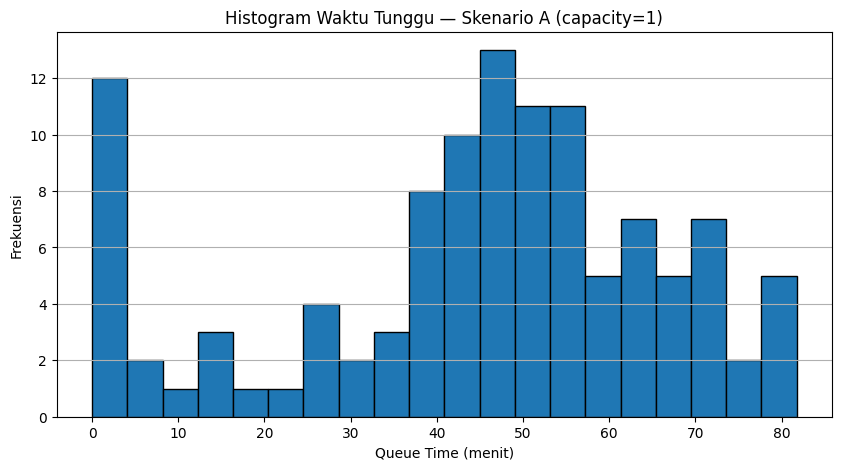

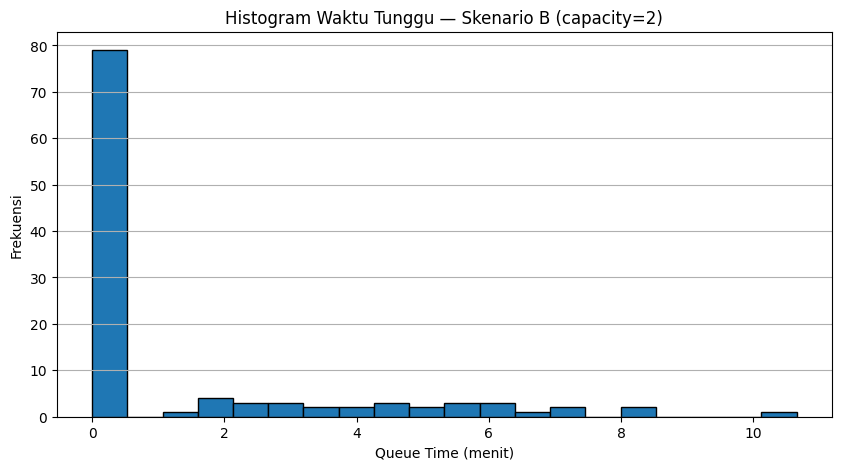

In [23]:
# Histogram waktu tunggu (queue_time)
plt.figure(figsize=(10,5))
plt.hist(df_A["queue_time"], bins=20, edgecolor="black")
plt.title("Histogram Waktu Tunggu — Skenario A (capacity=1)")
plt.xlabel("Queue Time (menit)")
plt.ylabel("Frekuensi")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(10,5))
plt.hist(df_B["queue_time"], bins=20, edgecolor="black")
plt.title("Histogram Waktu Tunggu — Skenario B (capacity=2)")
plt.xlabel("Queue Time (menit)")
plt.ylabel("Frekuensi")
plt.grid(axis="y")
plt.show()


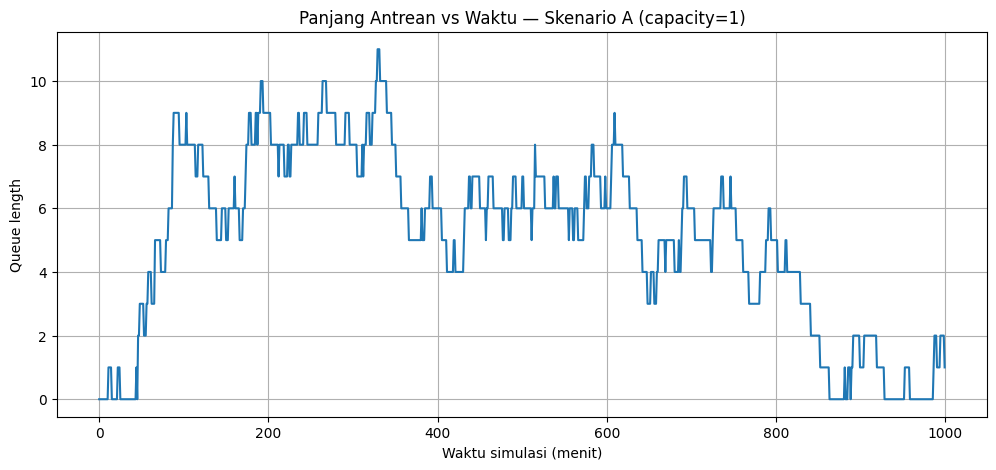

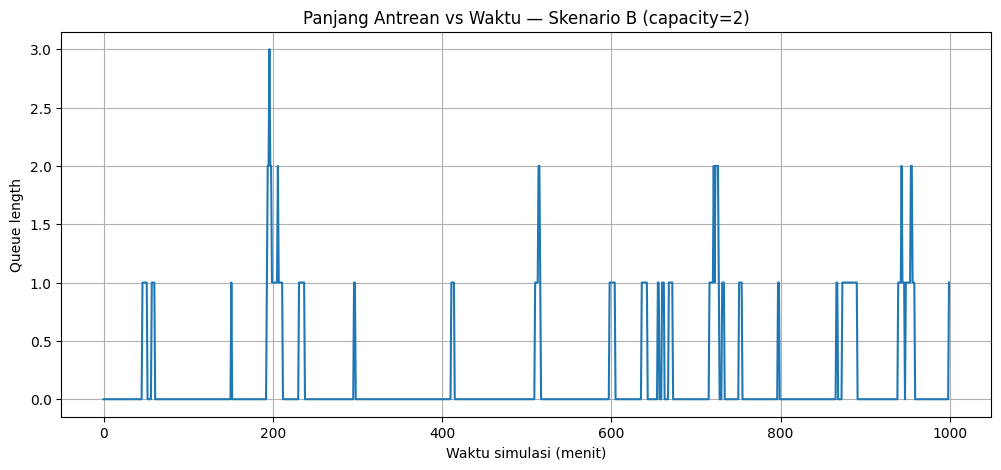

In [24]:
# Line chart panjang antrean seiring waktu
plt.figure(figsize=(12,5))
plt.plot(q_A["time"], q_A["queue_length"])
plt.title("Panjang Antrean vs Waktu — Skenario A (capacity=1)")
plt.xlabel("Waktu simulasi (menit)")
plt.ylabel("Queue length")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(q_B["time"], q_B["queue_length"])
plt.title("Panjang Antrean vs Waktu — Skenario B (capacity=2)")
plt.xlabel("Waktu simulasi (menit)")
plt.ylabel("Queue length")
plt.grid(True)
plt.show()


## 5) Kesimpulan (Kualitatif Ekonomi)

Panduan menulis kesimpulan (silakan sesuaikan dengan output Anda):

- Jika **avg_queue_time** dan **avg_queue_length** turun signifikan pada Skenario B, maka penambahan server efektif mengurangi kemacetan.  
- Pertimbangan ekonomi (kualitatif):
  - **Manfaat**: waktu tunggu turun → kepuasan naik, throughput naik, risiko keterlambatan turun.
  - **Biaya**: tambahan kasir/pekerja/alat/dock → gaji, investasi alat, ruang, maintenance.
- Jika penurunan waktu tunggu hanya kecil, penambahan server mungkin **tidak layak**.

Di bawah ini, notebook membuat ringkasan otomatis untuk membantu narasi Anda.


In [25]:
improvement = (summary.loc[0, "avg_queue_time"] - summary.loc[1, "avg_queue_time"])
improvement_pct = improvement / summary.loc[0, "avg_queue_time"] * 100 if summary.loc[0, "avg_queue_time"] > 0 else 0

print("\nPenurunan rata-rata waktu tunggu dari A ke B:")
print(f"- Δ avg_queue_time = {improvement:.2f} menit")
print(f"- Penurunan relatif ≈ {improvement_pct:.1f}%")

if improvement_pct >= 30:
    print("\nInterpretasi cepat: Penambahan kapasitas terlihat cukup berdampak (>=30%).")
elif improvement_pct >= 10:
    print("\nInterpretasi cepat: Penambahan kapasitas berdampak sedang (10–30%).")
else:
    print("\nInterpretasi cepat: Dampak penambahan kapasitas kecil (<10%).")

print("\nPanduan ekonomi (kualitatif):")
print("- Manfaat: waktu tunggu turun → kepuasan naik, throughput naik, risiko keterlambatan turun.")
print("- Biaya: tambahan kasir/pekerja/alat/dock → gaji, investasi alat, ruang, maintenance.")
print("- Keputusan: layak jika manfaat operasional > biaya tambahan (secara kualitatif).")


Penurunan rata-rata waktu tunggu dari A ke B:
- Δ avg_queue_time = 43.49 menit
- Penurunan relatif ≈ 97.0%

Interpretasi cepat: Penambahan kapasitas terlihat cukup berdampak (>=30%).

Panduan ekonomi (kualitatif):
- Manfaat: waktu tunggu turun → kepuasan naik, throughput naik, risiko keterlambatan turun.
- Biaya: tambahan kasir/pekerja/alat/dock → gaji, investasi alat, ruang, maintenance.
- Keputusan: layak jika manfaat operasional > biaya tambahan (secara kualitatif).


## 6) Ekspor Data (Opsional)

Jika Anda ingin menyimpan log simulasi sebagai CSV (misal untuk lampiran laporan), jalankan sel di bawah.


In [26]:
# Opsional: simpan log ke CSV
# df_A.to_csv("log_skenario_A.csv", index=False)
# df_B.to_csv("log_skenario_B.csv", index=False)
# q_A.to_csv("queue_trace_A.csv", index=False)
# q_B.to_csv("queue_trace_B.csv", index=False)

print("Siap! (Uncomment baris di atas jika ingin menyimpan CSV).")


Siap! (Uncomment baris di atas jika ingin menyimpan CSV).
